In [2]:
# Built-in
import os
import itertools
import multiprocessing
import math

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.stats.multitest import multipletests
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import manifold

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==0.24.2 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


In [3]:
pd.set_option('display.max_columns', 40)

In [4]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

In [5]:
REPLICATE = 'replicate0'

In [6]:
adata = sc.read( os.path.join(settings.data_path, "post-wt-clustering.h5ad"))
adata

AnnData object with n_obs × n_vars = 299193 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

Many of these images are "inspired" by https://www.sciencedirect.com/science/article/pii/S0896627323008449?via%3Dihub

FIgure 1 - lots of cluster expression

# Find cluster markers 
Yaman did this is 02_clustering but its no longer stored in adata.obs? It is in `figures/scanpy_cellranger_fixed_sex/top_markers_from_highly_variable.xlsx` tho

UPDATE: fixed now in the updated subsampled bois, stored in `adata.uns['rank_genes_groups']`

In [7]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = [str(i) for i in range(13)]
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT','Oligodendrocytes',
                'L5/6-IT','Astrocytes','L5-ET','CIN-PV','OPC',
                 'CIN-SST','L5/6-NP','CIN-VIP']

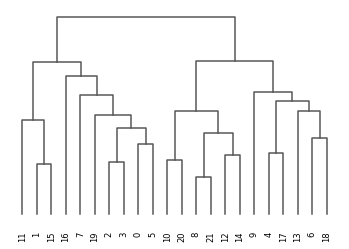

In [8]:
sc.tl.dendrogram(adata, 'leiden')
sc.pl.dendrogram(adata, 'leiden')

dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [9]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup

,id,name
11,11,L5/6-NP
1,1,L6-CT
7,7,L5-ET
2,2,L4/5-IT
3,3,L4-IT
0,0,L2/3-IT
5,5,L5/6-IT
10,10,CIN-SST
8,8,CIN-PV
12,12,CIN-VIP


In [10]:
# for some reason this removes the categorical attribute from the leiden column
# beware
adata.obs = ( adata.obs.reset_index()
             .merge(cluster_lookup, left_on='leiden', right_on='id', how='left')
             .set_index('index') )

# Number of DE Genes - time covariate - stacked bar plot, timecourse 

Proceeding with subsampled memento data because it will be consistent with some other images, but should we be using initial?

Ken's observations - more cells means higher confidence, so DE genes are more likely to show up in large population clusters

In [11]:
def process_combination(drug, cluster, replicate='replicate0'):
    subset_memento = pd.read_excel(
        f"memento_output/{replicate}/memento_DE_{drug}_time_covariate.xlsx",
        sheet_name=f'Cluster {cluster}'
    )
    subset_memento = subset_memento[['gene', 'de_coef', 'de_pval_adj']]
    subset_memento = subset_memento.rename(columns={
        'de_coef':'subset_de',
        'de_pval_adj':'subset_de_padj'
    })
    
    subset_memento['drug'] = drug
    subset_memento['cluster'] = cluster
    return subset_memento

In [12]:
trt_drugs = drugs[1:]
print(len(list(itertools.product(trt_drugs,clusters))))
trt_drugs,clusters

26


(['Ket', 'Psilo'],
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

In [13]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_combination(drug, cluster, replicate='replicate0') 
    for drug,cluster 
    in progressbar_product(trt_drugs,clusters)
]
memento_subset = pd.concat(combination_mementos)
print(memento_subset.shape)
memento_subset.head()

  0%|          | 0/26 [00:00<?, ?it/s]

(290495, 5)


,gene,subset_de,subset_de_padj,drug,cluster
0,Tiparp,-0.899786,0.036414,Ket,0
1,Btg2,-1.242213,0.036414,Ket,0
2,Slit2,-0.304929,0.036414,Ket,0
3,A730060N03Rik,0.620915,0.043640,Ket,0
4,Gm32250,0.258538,0.043640,Ket,0


In [14]:
def bar_plot_de_genes(memento_df, replicate='unidentified'):
    de_counts = memento_df.query('subset_de_padj < 0.05').copy()
    de_counts['de_direction'] = de_counts['subset_de'].apply(lambda de: 'up' if de > 0 else 'down')
    de_counts = de_counts.groupby(['cluster','drug','de_direction'])['gene'].size() \
        .reset_index() \
        .merge(cluster_lookup, how='left', left_on='cluster', right_on='id') \
        .sort_values('name')

    sns.set_theme(style='whitegrid')
    g = sns.catplot(
        data=de_counts, kind='bar',
        x='name', y='gene', hue='drug', col='de_direction',
        col_order=['down','up'],
        height=4, aspect=16.0/9,
    )
    g.set_titles(template='{col_name} DE') \
        .set_axis_labels(x_var='', y_var='Number of Genes') \
        .set_xticklabels(rotation=45, ha='right')
    g.figure.subplots_adjust(top=0.85)
    g.figure.suptitle(f"Number of DE Genes (adj p-value cutoff 0.05) (Replicate {replicate})")
    return g

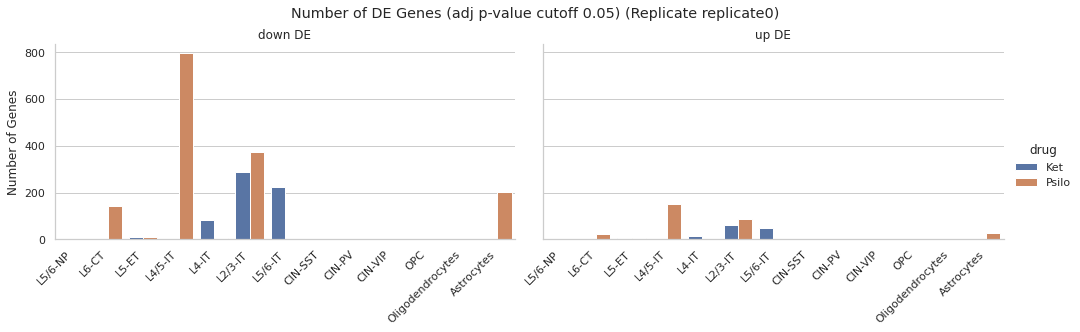

In [15]:
g = bar_plot_de_genes(memento_subset, 'replicate0')
g.savefig(os.path.join(settings.fig_path, f'num_DE_genes_by_cluster_replicate0.png'))

# Do it again for replicate 1

In [16]:
REPLICATE = 'replicate1'

In [17]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos_1 = [
    process_combination(drug, cluster, replicate='replicate1') 
    for drug,cluster 
    in progressbar_product(trt_drugs,clusters)
]
memento_subset_1 = pd.concat(combination_mementos_1)
print(memento_subset_1.shape)
memento_subset_1.head()

  0%|          | 0/26 [00:00<?, ?it/s]

(290495, 5)


,gene,subset_de,subset_de_padj,drug,cluster
0,Btg2,-1.242213,0.035504,Ket,0
1,Tiparp,-0.899786,0.035504,Ket,0
2,Abi3bp,-0.522939,0.035504,Ket,0
3,Slit2,-0.304929,0.035504,Ket,0
4,Pim3,-0.902302,0.035504,Ket,0


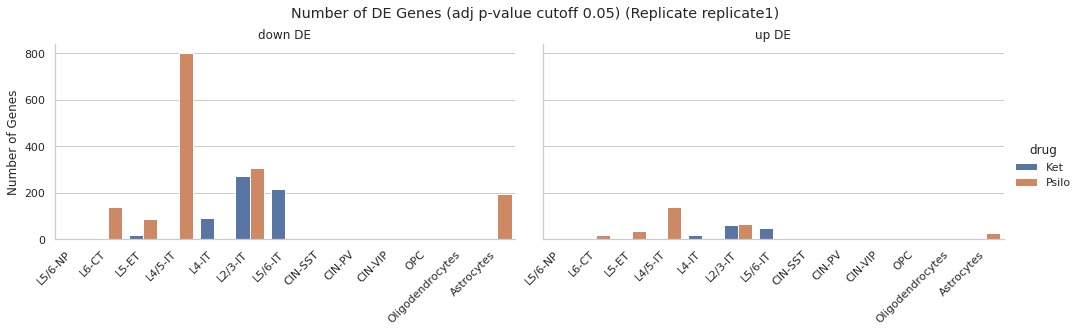

In [18]:
g = bar_plot_de_genes(memento_subset_1, 'replicate1')
g.savefig(os.path.join(settings.fig_path, f'num_DE_genes_by_cluster_replicate1.png'))

# Overlap Heatmap/dotmap

## Idea 1: hypergeometric overlap

Generate $p_{\text{hyper}}$ values testing the ovelap between each cluster-drug-direction's DE genes
These should come from a 1 sided hypothesis test

**Example**

- N population size (pool of genes) - $|\text{all genes}|$
- n draws - $|A|$
- K possible successes - $|B|$
- k observed successes - $|A \cap B|$

**too bad**

p-values generated from such a test either overlap so much that the p-value is effectively 0 or one of the sets $A$ or $B$ is empty and the p-value is 1. The resulting heatmap is a useless binary checkerboard.

## Idea 2: Jaccard similarity

Ignore the population size, and compute 

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|} \in [0,1]$$

In [19]:
# de_overlaps = memento_subset.query('subset_de_padj < 0.051').copy()
# de_overlaps['de_direction'] = de_overlaps['subset_de'].apply(lambda de: 'up' if de > 0 else 'down')
# de_overlaps = de_overlaps.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
# de_overlaps = de_overlaps[['gene','drug','name','de_direction']]
# de_overlaps = de_overlaps.sort_values('name')
# de_overlaps = de_overlaps.groupby(['drug','de_direction','name'])\
#     .agg({'gene': lambda x: set(x.tolist())})['gene'] \
#     .to_dict()
# de_overlaps

In [57]:
no_cutoff_de_directional_overlaps = memento_subset.copy()
no_cutoff_de_directional_overlaps['de_direction'] = no_cutoff_de_directional_overlaps['subset_de'].apply(lambda de: 'up' if de > 0 else 'down')
no_cutoff_de_directional_overlaps = no_cutoff_de_directional_overlaps.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
no_cutoff_de_directional_overlaps = no_cutoff_de_directional_overlaps[['gene','drug','name','de_direction','subset_de']]
no_cutoff_de_directional_overlaps = no_cutoff_de_directional_overlaps.sort_values('name')
no_cutoff_de_directional_overlap_groups = no_cutoff_de_directional_overlaps.groupby(['drug','de_direction','name']) 
no_cutoff_de_directional_overlaps = {}
for name, group in no_cutoff_de_directional_overlap_groups:
    no_cutoff_de_directional_overlaps[name] = set(
        group.sort_values('subset_de', key=abs, ascending=False) \
             .reset_index() \
             .loc[0:1000, 'gene'] \
             .to_list()
    )
del no_cutoff_de_directional_overlap_groups
no_cutoff_de_directional_overlaps

{('Ket', 'down', 'L5/6-NP'): {'Rab33a',
  'Gm12473',
  'Egr1',
  'Slc6a1',
  'Mcm4',
  'Gm40331',
  'Mvb12a',
  'Gale',
  'Zscan12',
  'C230012O17Rik',
  'Fank1',
  'AC163638.2',
  'Rragc',
  'Kdm6b',
  'Ier5l',
  'Psmd8',
  'Insig1',
  'Vrk3',
  'Slc35g2',
  'Mob3c',
  'Med28',
  'Tusc2',
  'Coq10b',
  'Mkks',
  'Tmem130',
  'Eif3i',
  'Selenow',
  'Nubpl',
  'Rnf4',
  'Arhgef33',
  'Mapkapk2',
  'Yif1b',
  'Gm42659',
  'Tex264',
  'Gm3173',
  'Vasp',
  'Rtl8b',
  'Polh',
  'Irf2bpl',
  'Tubb3',
  'Zfp653',
  'Per1',
  'Dctn3',
  'Usf1',
  'Lig1',
  'Mettl18',
  'Gdpgp1',
  'Gm3002',
  'Klhl9',
  'Uqcrb',
  'Baiap2l2',
  'Phlda1',
  'Gm45447',
  'Gpr137',
  'Ddit3',
  'Coro2a',
  'Gm21691',
  'Tomm20l',
  'Slc52a2',
  'Cnih2',
  'Degs1',
  'Rbm15b',
  'Bpnt1',
  'Ciart',
  'Nr4a3',
  'Tmem107',
  'Oacyl',
  'Slc9b2',
  'Polrmt',
  'Tmem126a',
  'Nudt8',
  'Gspt2',
  'Dpagt1',
  'Gapdh',
  'Mturn',
  'Psme2',
  'Osbpl7',
  '4632404H12Rik',
  'Cirbp',
  'Pin4',
  'Gm11802',
  'Gm26812',

In [58]:
list(no_cutoff_de_directional_overlaps)[0]

('Ket', 'down', 'L5/6-NP')

In [187]:
def overlap_matrix(drug, direction):
    heatmap_idx = cluster_lookup['name'].to_list()
    jaccard_similarities = np.zeros((len(heatmap_idx), len(heatmap_idx)))
    for i,i_name in enumerate(heatmap_idx):
        for j,j_name in enumerate(heatmap_idx):
            try:
                A = no_cutoff_de_directional_overlaps[(drug,direction,i_name)]
                B = no_cutoff_de_directional_overlaps[(drug,direction,j_name)]
            except KeyError:
                A,B = set(),set()
            A = A if isinstance(A, set) else set()
            B = B if isinstance(B, set) else set()
            if i == j:
                jaccard_similarities[i][j] = 0
                continue

            try:
                jaccard_similarities[i][j] = len(A.intersection(B)) / len(A.union(B))
            except:
                jaccard_similarities[i][j] = 0
    return jaccard_similarities

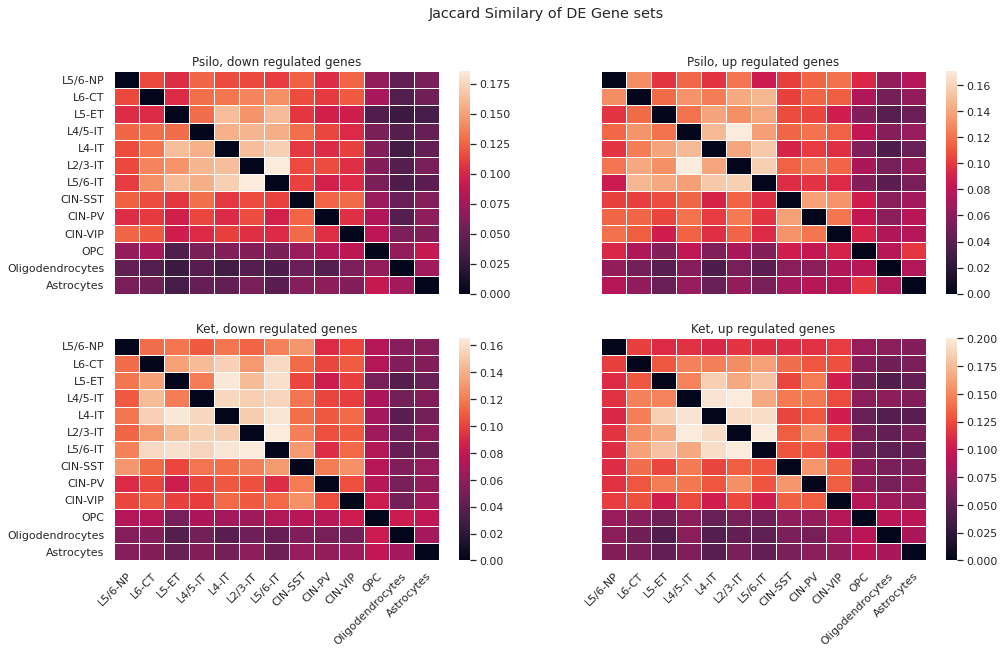

In [188]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=True)
heatmap_drugs = ['Psilo','Ket']
heatmap_directions = ['down','up']
heatmap_idx = cluster_lookup['name'].to_list()

for row, col in itertools.product([0,1],[0,1]):
    sns.heatmap(
        overlap_matrix(heatmap_drugs[row], heatmap_directions[col]), 
        linewidth=0.5, 
        ax=axes[row][col]
    )
    axes[row][col].set_title(f"{heatmap_drugs[row]}, {heatmap_directions[col]} regulated genes")
    axes[row][col].set_xticks(np.arange(len(heatmap_idx))+0.8, labels=heatmap_idx, rotation=45, ha='right')
    axes[row][col].set_yticks(np.arange(len(heatmap_idx))+0.5, labels=heatmap_idx, rotation=0)

fig.suptitle("Jaccard Similary of DE Gene sets")
fig.savefig(os.path.join(settings.fig_path, "subset_heatmap_de_gene_overlap.png"))

# Overlap Swoosh Grid

In [189]:
no_cutoff_de_overlaps = memento_subset.copy()
no_cutoff_de_overlaps = no_cutoff_de_overlaps.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
no_cutoff_de_overlaps = no_cutoff_de_overlaps[['gene','drug','name','subset_de']]
no_cutoff_de_overlaps = no_cutoff_de_overlaps.sort_values('name')
no_cutoff_de_overlap_groups = no_cutoff_de_overlaps.groupby(['drug','name']) 
no_cutoff_de_overlaps = {}
for name, group in no_cutoff_de_overlap_groups:
    no_cutoff_de_overlaps[name] = set(
        group.sort_values('subset_de', key=abs, ascending=False) \
             .reset_index() \
             .loc[0:1000, 'gene'] \
             .to_list()
    )
del no_cutoff_de_overlap_groups
no_cutoff_de_overlaps

{('Ket', 'L5/6-NP'): {'Rab33a',
  'Zbtb34',
  'Rapgef4os2',
  'Egr1',
  'Slc6a1',
  'Gm40331',
  'Atpaf2',
  'Gale',
  'Cdh24',
  'Kdm6b',
  'Lrrc47',
  'Slc35g2',
  'Mob3c',
  'Med28',
  'Tusc2',
  'Cln3',
  'Coq10b',
  'Gm41764',
  'Cybc1',
  'Mkks',
  'Tmem130',
  'Rgs22',
  'Tsc2',
  'Angpt1',
  'Zfp729a',
  '4930593A02Rik',
  'Commd6',
  'Slc35a2',
  'Rnf4',
  'Hectd2os',
  'Arhgef33',
  'Mapkapk2',
  'Yif1b',
  'Fndc8',
  'Gm42659',
  'Tex264',
  'Gm3173',
  'Greb1',
  'Rtl8b',
  'Stk32c',
  'Vasp',
  'Polh',
  'Tubb3',
  'Zfp653',
  'Irf2bpl',
  'Zfp959',
  'Usf1',
  'Mettl18',
  'Gdpgp1',
  'Gm3002',
  'Baiap2l2',
  'Phlda1',
  'Gm45447',
  '4933423P22Rik',
  'Ddit3',
  'Tomm20l',
  'Slc52a2',
  'Gm48749',
  'March10',
  '4933436I20Rik',
  'Ttc23',
  'Ciart',
  'Hgsnat',
  'Cnih2',
  'Nr4a3',
  'Rbm15b',
  'Nudt8',
  'Gm49980',
  'Maged2',
  'Nol3',
  'Fcor',
  'Gm16093',
  'Cirbp',
  'Pin4',
  'Gm26812',
  'Gm30648',
  '9330175M20Rik',
  'Rsf1os2',
  'Gm13872',
  'Dolk',
  'Po

In [190]:
def swoosh_matrix_fc(drug, cluster_1, cluster_2):
    A = no_cutoff_de_overlaps[(drug,cluster_1)]
    B = no_cutoff_de_overlaps[(drug,cluster_2)]
    A = A if isinstance(A, set) else set()
    B = B if isinstance(B, set) else set()
    overlap_gene_list = list(A.intersection(B))
    
    return memento_subset \
        .merge(cluster_lookup, how='inner', left_on='cluster', right_on='id') \
        .query(f'drug == "Psilo" and name in ["{cluster_1}","{cluster_2}"]') \
        .loc[:, ['gene','subset_de','name']] \
        .pivot(columns='name', values='subset_de', index='gene') \
        .assign(home = lambda row: row[cluster_1], away = lambda row: row[cluster_2]) \
        .loc[overlap_gene_list, ['home','away']] \
        .assign(residual = lambda row: row['away'] - row['home']) \
        .sort_values('home', ascending=False)

swoosh_matrix_fc('Psilo', 'L5/6-NP', 'L5-ET')

name,home,away,residual
gene,,,
Cldn11,1.415935,0.456913,-0.959022
Il27,1.239499,0.405297,-0.834202
Slc1a3,1.160621,1.176248,0.015627
Cdk18,1.022302,0.387008,-0.635294
E530011L22Rik,1.019839,0.437672,-0.582168
...,...,...,...
Junb,-0.808879,-0.412296,0.396583
Tek,-0.836713,-0.403294,0.433420
Mob3a,-0.862667,-0.462106,0.400562


In [191]:
def swoosh_matrix_rank(drug, cluster_1, cluster_2):
    A = no_cutoff_de_overlaps[(drug,cluster_1)]
    B = no_cutoff_de_overlaps[(drug,cluster_2)]
    A = A if isinstance(A, set) else set()
    B = B if isinstance(B, set) else set()
    overlap_gene_list = list(A.intersection(B))
    
    thing = memento_subset \
        .merge(cluster_lookup, how='inner', left_on='cluster', right_on='id') \
        .query(f'drug == "Psilo" and name in ["{cluster_1}","{cluster_2}"]') \
        .loc[:, ['gene','subset_de','name']] \
        .pivot(columns='name', values='subset_de', index='gene') \
        .assign(home = lambda row: row[cluster_1], away = lambda row: row[cluster_2]) \
        .loc[overlap_gene_list, ['home','away']] \
        .sort_values('home', ascending=False) \
        .rank()
    thing = (thing - 1) / (thing['home'].max() - 1) * 2 - 1
    thing = thing.assign(rank_difference = lambda row: row['away'] - row['home'])
    return thing

swoosh_matrix_rank('Psilo', 'L5/6-NP', 'L6-CT')

name,home,away,rank_difference
gene,,,
Cldn11,1.000000,0.801047,-0.198953
Il27,0.989529,0.979058,-0.010471
Slc1a3,0.979058,0.905759,-0.073298
Cdk18,0.968586,0.790576,-0.178010
Rab26os,0.958115,0.706806,-0.251309
...,...,...,...
Junb,-0.958115,-0.602094,0.356021
Zfp748,-0.968586,0.560209,1.528796
Gm20470,-0.979058,-0.287958,0.691099


## Heatmap of FC

CPU times: user 4min 26s, sys: 7.03 s, total: 4min 33s
Wall time: 4min 34s


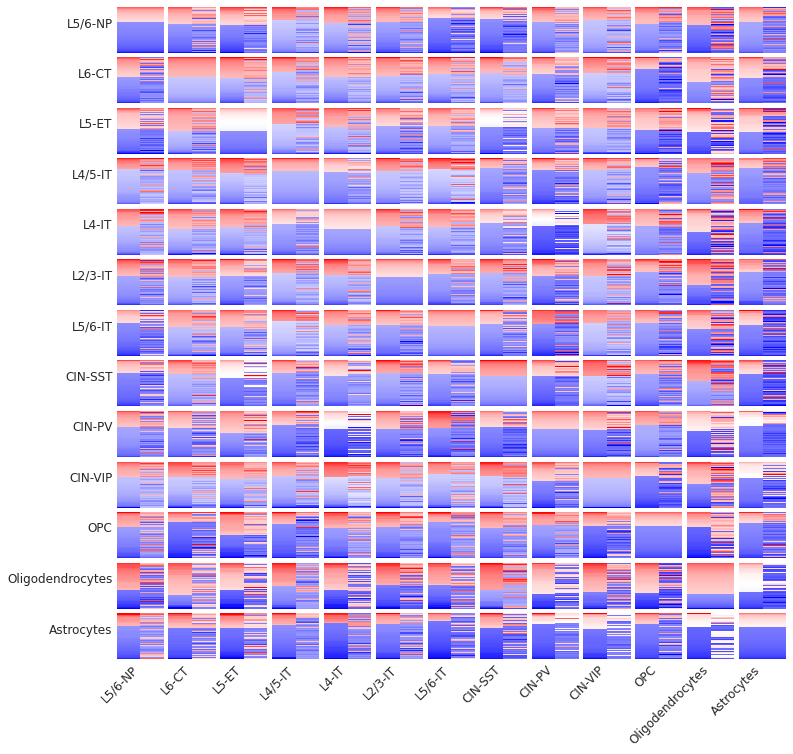

In [192]:
%%time
heatmap_idx = cluster_lookup['name'].to_list()
fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
# for row, col in itertools.product([0,1,11,12], [0,1,2]):
    ax = axes[row][col]
    sns.heatmap(
        swoosh_matrix_fc('Psilo', heatmap_idx[row], heatmap_idx[col]).loc[:,['home','away']],
        linewidth=0, cmap='bwr', cbar=False,
        xticklabels=False, yticklabels=False,
        ax = ax
    )
    ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
    if row == len(heatmap_idx)-1:
        ax.set_xlabel(heatmap_idx[col], rotation = 45, horizontalalignment='right')
    if col == 0:
        ax.set_ylabel(heatmap_idx[row], rotation = 0, horizontalalignment='right')

fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig(os.path.join(settings.fig_path, 'subset_swoosh_grid_heatmap_psilo_fc.png'))

## Heatmap of Rank

CPU times: user 4min 29s, sys: 6.48 s, total: 4min 35s
Wall time: 4min 37s


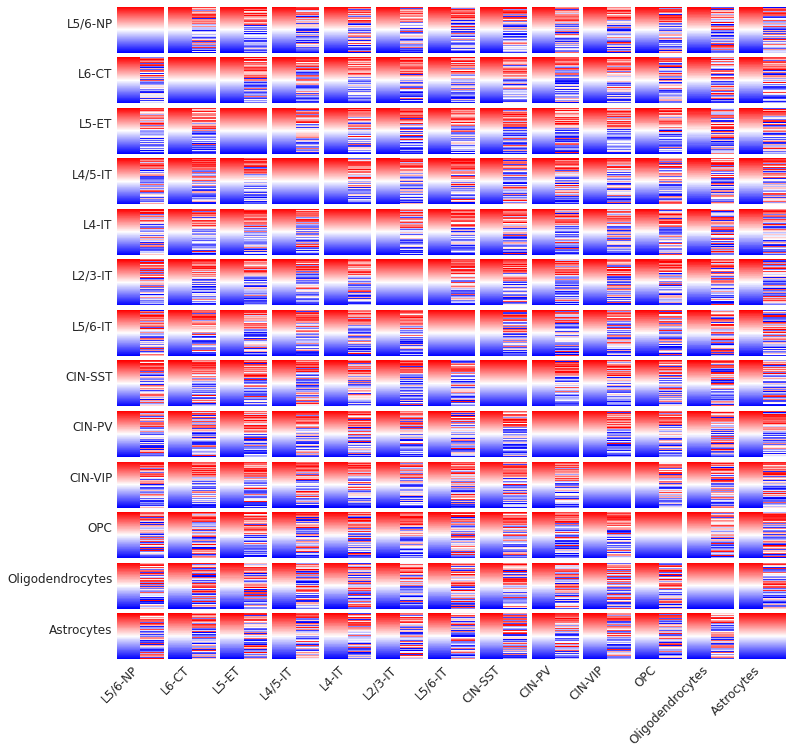

In [193]:
%%time
heatmap_idx = cluster_lookup['name'].to_list()
fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
# for row, col in itertools.product([0,1,11,12], [0,1,2]):
    ax = axes[row][col]
    sns.heatmap(
        swoosh_matrix_rank('Psilo', heatmap_idx[row], heatmap_idx[col]).loc[:,['home','away']],
        linewidth=0, cmap='bwr', cbar=False,
        xticklabels=False, yticklabels=False,
        ax = ax
    )
    ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
    if row == len(heatmap_idx)-1:
        ax.set_xlabel(heatmap_idx[col], rotation = 45, horizontalalignment='right')
    if col == 0:
        ax.set_ylabel(heatmap_idx[row], rotation = 0, horizontalalignment='right')

fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig(os.path.join(settings.fig_path, 'subset_swoosh_grid_heatmap_psilo_rank.png'))

## Glyphs of FC Residuals

CPU times: user 26.2 s, sys: 262 ms, total: 26.5 s
Wall time: 26.3 s


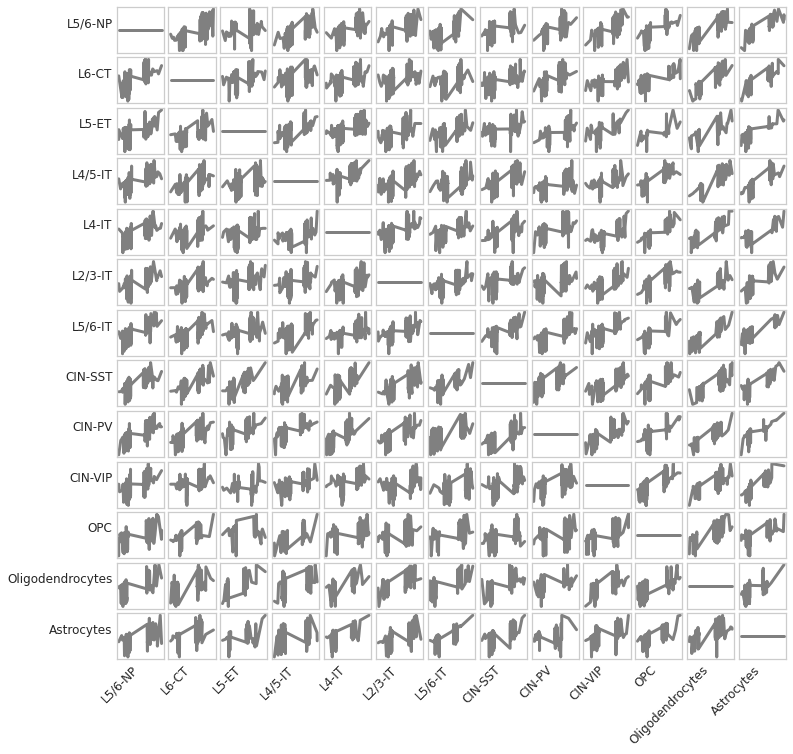

In [194]:
%%time
heatmap_idx = cluster_lookup['name'].to_list()
fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
# for row, col in itertools.product([0,1,11,12], [0,1,2]):
    ax = axes[row][col]
    sns.lineplot(
        data = swoosh_matrix_fc('Psilo', heatmap_idx[row], heatmap_idx[col]),
        x = 'away', y='residual',
        linewidth = 3, color = 'grey',
        ax = ax
    )
    ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
    if row == len(heatmap_idx)-1:
        ax.set_xlabel(heatmap_idx[col], rotation = 45, horizontalalignment='right')
    if col == 0:
        ax.set_ylabel(heatmap_idx[row], rotation = 0, horizontalalignment='right')

fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig(os.path.join(settings.fig_path, 'subset_swoosh_grid_glyphs_psilo_fc_residual.png'))

## Glyphs of Rank Difference

CPU times: user 26.4 s, sys: 1.87 s, total: 28.2 s
Wall time: 28.1 s


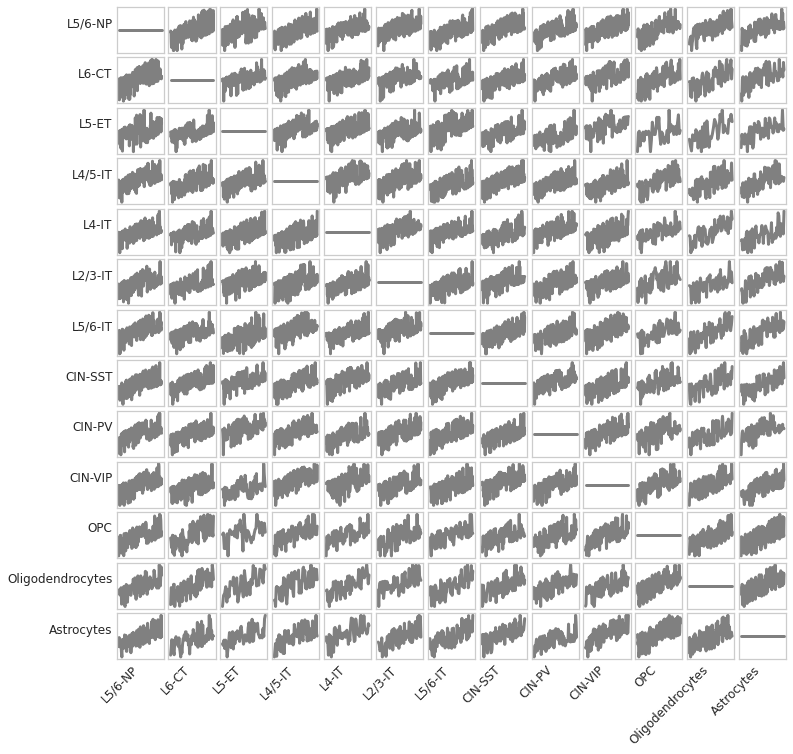

In [195]:
%%time
heatmap_idx = cluster_lookup['name'].to_list()
fig, axes = plt.subplots(len(heatmap_idx), len(heatmap_idx), figsize=(12, 12))

for row, col in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
# for row, col in itertools.product([0,1,11,12], [0,1,2]):
    ax = axes[row][col]
    sns.lineplot(
        data = swoosh_matrix_rank('Psilo', heatmap_idx[row], heatmap_idx[col]),
        x = 'away', y = 'rank_difference',
        linewidth = 3, color = 'grey',
        ax = ax
    )
    ax.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
    if row == len(heatmap_idx)-1:
        ax.set_xlabel(heatmap_idx[col], rotation = 45, horizontalalignment='right')
    if col == 0:
        ax.set_ylabel(heatmap_idx[row], rotation = 0, horizontalalignment='right')

fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig(os.path.join(settings.fig_path, 'subset_swoosh_grid_glyphs_psilo_rank_difference.png'))